In [44]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Function to reduce memory usage by downcasting numeric columns
def reduce_mem_usage(df):
    """ 
    Reduce memory usage of a pandas DataFrame by downcasting numeric columns.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

# Loading the dataset
df = pd.read_csv('data.csv', low_memory=False)

# Reduce memory usage of the dataset
df = reduce_mem_usage(df)


# Display the first few rows of the dataset
df.head()


Memory usage after optimization: 24.81 MB
Decreased by 25.0%


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.550781,17856.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.390625,17856.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.750000,17856.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.390625,17856.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.390625,17856.0,United Kingdom


In [49]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Or ignore specific warning types
warnings.filterwarnings("ignore", category=RuntimeWarning)
# Check for missing values
df.isnull().sum()

# Dropping rows with missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

# Converting InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
invalid_dates = df[df['InvoiceDate'].isna()]
print("Invalid dates:", invalid_dates)
df = df.dropna(subset=['InvoiceDate'])


# Filter out negative or zero quantities
df = df[df['Quantity'] > 0]

# Filter out negative or zero unit prices
df = df[df['UnitPrice'] > 0]

# Exploratory Data Analysis
df.describe()


Invalid dates: Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,168631.000000,168631,168631.000000,168631.0
mean,13.079546,2011-07-01 16:48:32.007638016,NaN,NaN
min,1.000000,2010-12-01 08:26:00,0.040009,12344.0
25%,2.000000,2011-04-01 11:34:00,1.250000,13880.0
50%,6.000000,2011-07-12 17:21:00,1.950195,15192.0
75%,12.000000,2011-10-11 14:59:00,3.750000,16880.0
max,80995.000000,2011-12-09 12:50:00,8144.000000,18288.0
std,201.856371,NaN,NaN,NaN


In [51]:
from mlxtend.frequent_patterns import apriori, association_rules

# Grouping the data by InvoiceNo and StockCode
basket = (df.groupby(['InvoiceNo', 'StockCode'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

# Verify basket data
print(basket.head())


StockCode  10002  10080  10120  10123C  10124A  10124G  10125  10133  10135  \
InvoiceNo                                                                     
536365       0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0    0.0   
536366       0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0    0.0   
536367       0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0    0.0   
536368       0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0    0.0   
536369       0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0    0.0   

StockCode  11001  ...  90214U  90214V  90214W  90214Y  90214Z  BANK CHARGES  \
InvoiceNo         ...                                                         
536365       0.0  ...     0.0     0.0     0.0     0.0     0.0           0.0   
536366       0.0  ...     0.0     0.0     0.0     0.0     0.0           0.0   
536367       0.0  ...     0.0     0.0     0.0     0.0     0.0           0.0   
536368       0.0  ...     0.0     0.0     0.0     0

In [56]:
# Encoding the data: if the quantity of a product is greater than 0, then 1 else 0
def encode_units(x):
    return 1 if x >= 1 else 0

basket_sets = basket.map(encode_units)

# Verify basket_sets data
print(basket_sets.head())

StockCode  10002  10080  10120  10123C  10124A  10124G  10125  10133  10135  \
InvoiceNo                                                                     
536365         0      0      0       0       0       0      0      0      0   
536366         0      0      0       0       0       0      0      0      0   
536367         0      0      0       0       0       0      0      0      0   
536368         0      0      0       0       0       0      0      0      0   
536369         0      0      0       0       0       0      0      0      0   

StockCode  11001  ...  90214U  90214V  90214W  90214Y  90214Z  BANK CHARGES  \
InvoiceNo         ...                                                         
536365         0  ...       0       0       0       0       0             0   
536366         0  ...       0       0       0       0       0             0   
536367         0  ...       0       0       0       0       0             0   
536368         0  ...       0       0       0      

In [66]:
# Apply the Apriori algorithm
frequent_itemsets = apriori(basket_sets, min_support=0.1, use_colnames=True,verbose=1)

# Display frequent itemsets
frequent_itemsets.head()
item_frequencies = basket_sets.sum().sort_values(ascending=False)
print(item_frequencies.head())
print(frequent_itemsets.shape)
# Generating the rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.5)
print(rules.shape)


# Display the association rules
rules.head()

# Filter rules by confidence
rules = rules[(rules['confidence'] >= 0.1) & (rules['lift'] >= 1)]

# Display the filtered rules
rules.to_string()



StockCode
85123A    888
22423     736
85099B    680
84879     585
47566     573
dtype: int64
(1, 2)
(0, 10)


'Empty DataFrame\nColumns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]\nIndex: []'

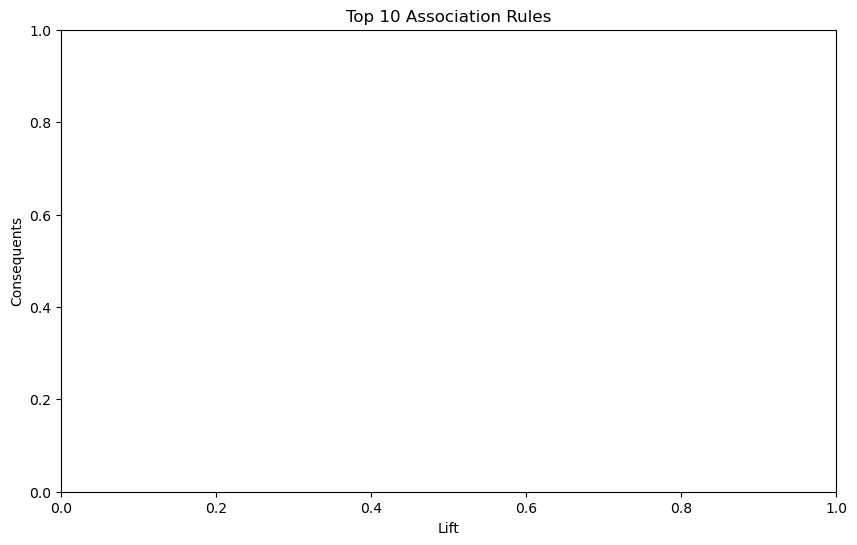

In [68]:
# Sorting rules by lift
rules = rules.sort_values('lift', ascending=False)

# Display top rules
top_rules = rules.head(10)
top_rules

# Plotting the top rules
plt.figure(figsize=(10,6))
sns.barplot(x='lift', y='consequents', data=top_rules, palette='viridis')
plt.title('Top 10 Association Rules')
plt.xlabel('Lift')
plt.ylabel('Consequents')
plt.show()

# Recommendations
for index, rule in top_rules.iterrows():
    print(f"Recommendation {index+1}: If a customer buys {rule['antecedents']}, they are also likely to buy {rule['consequents']}. Consider bundling these products together or offering discounts for purchasing these items together.")


In [72]:
# Conclusion
print("Based on the market basket analysis, no key product associations were identified. These associations can't be leveraged in various marketing strategies such as product bundling, targeted promotions, and personalized recommendations. This Dataset does not not have strong associations, or the transactions could be too diverse for the current thresholds. In this case, you may need to reconsider your approach or gather more data. By understanding the purchasing behavior of customers, the company can enhance customer satisfaction and increase sales.")


Based on the market basket analysis, no key product associations were identified. These associations can't be leveraged in various marketing strategies such as product bundling, targeted promotions, and personalized recommendations. This Dataset does not not have strong associations, or the transactions could be too diverse for the current thresholds. In this case, you may need to reconsider your approach or gather more data. By understanding the purchasing behavior of customers, the company can enhance customer satisfaction and increase sales.
